<a href="https://colab.research.google.com/github/mdld/flux/blob/main/STUDY01_FS_TS_CLASSIFY_v1_0_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

In [ ]:
# all the constants to tune the model etc. live here
BATCH_SIZE=32
CLASSES=9
LAYER_COUNT=5
HISTORY_SIZE=32 # I made this a power of 2 for the dilated convolutions to fit nicely

In [ ]:
from tensorflow import keras



In [ ]:
import os
try:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/.shortcut-targets-by-id/1Ceqqrb_wsA6SDV82I0HBzLQ17ezMt9v2/MariePHD
except ImportError:
  print("Can't import colab drive, hopefully this means you're running locally")

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1Ceqqrb_wsA6SDV82I0HBzLQ17ezMt9v2/MariePHD


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Normalise Function


In [ ]:
def normalize(dataset):
    #dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))*1
    dataNorm=(dataset/256.0)-1
#    dataNorm=(dataset/512.0)-1
    dataNorm["Label"]=dataset["Label"]
    return dataNorm

# Read Sensor Data

In [ ]:
## Iterate through the Flux Shirt Right Hand Side Sensor Datafiles, reading them into Pandas dataframes named file0 to file8

alldata = None
i = -1
file_list = ['STUDY01/BLEdata_263_2_D2_MP_edit.csv',    #file0
             'STUDY01/BLEdata_263_9_D2_SL_edit.csv',    #file1
             'STUDY01/BLEdata_263_3_D1_PU_edit.csv',    #file2
             'STUDY01/BLEdata_263_4_D2_PR_edit.csv',    #file3
             'STUDY01/BLEdata_263_5_D2_DA_edit.csv',    #file4
             'STUDY01/BLEdata_263_7_D1_GL_edit.csv',    #file5
             'STUDY01/BLEdata_263_8_D2_FT_edit.csv',    #file6
             'STUDY01/BLEdata_263_11_D2_WR_edit.csv',   #file7
             'STUDY01/BLEdata_263_13_D2_FK_edit.csv']   #file8

for f in file_list:
  i = i + 1
  #print('file'+str(i))         
  file_name = 'file'+str(i)

  file = pd.read_csv(f, skiprows=1, delimiter = ',', names = ['Label', 'L/R', 'DT', 'U', 'L1', 'A0-RFU', 'L2', 
                                                                        'A1-RFC', 'L3', 'A2-RBC', 'L4', 'A3-RBU', 'L5', 
                                                                        'A4-Arm', 'L6', 'A5-Arm', 'L8', 'D8-A8', 'L9', 'D9-A9'])  
  #print(f),print(file.head(3))  #check the contents of each file
  file = file.drop(columns=['L/R','DT','U','L1','L2','L3','L4','L5','L6','L8','D8-A8','L9','D9-A9'])
  #print(f),print('file'+str(i)),print(file_name.head(3))  #check the contents of each file

  file = normalize(file)
  #print(f),print(file_name),print(file.head(3))  #check the contents of each file
  #print(f, file_name, file.Label.count(), ' All')
  file = file.groupby(file.Label)
  file = file.get_group(1)
  #print(f, file_name, file.Label.count(), ' Labelled')
  file['Label'] = i
  #print(f),print(file_name),print(file.head(3))  #check the contents of each file

  alldata = pd.concat([alldata, file], axis=0)
  #print(f),print(file_name),print(alldata.head(3), print(alldata.tail(3)))  #check the contents of each file

  # convert to numpy array (all data, all 9 classes)
  alldata_np = alldata.to_numpy()
  x_data = alldata_np[:,1:]
  y_data = alldata_np[:,0]

# Prepare data using Joe's generator code

In [ ]:
from kerasgenerators import *

In [ ]:
print("ORIG:",x_data.shape,y_data.shape)

ORIG: (8826, 6) (8826,)


In [ ]:
in_dataset=LabelledHistoryGenerator(source_x=x_data,label_y=y_data,batch_size=BATCH_SIZE,history_x=HISTORY_SIZE,history_y=1)

in_dataset=ShuffledGenerator(in_dataset,seed=3)

train_dataset=TestSplitGenerator(in_dataset,split=0.5,is_test=False)
non_training_dataset=TestSplitGenerator(in_dataset,split=0.5,is_test=True)

validate_dataset=TestSplitGenerator(non_training_dataset,split=0.5,is_test=False)
test_dataset=TestSplitGenerator(non_training_dataset,split=0.5,is_test=True)


# Keras

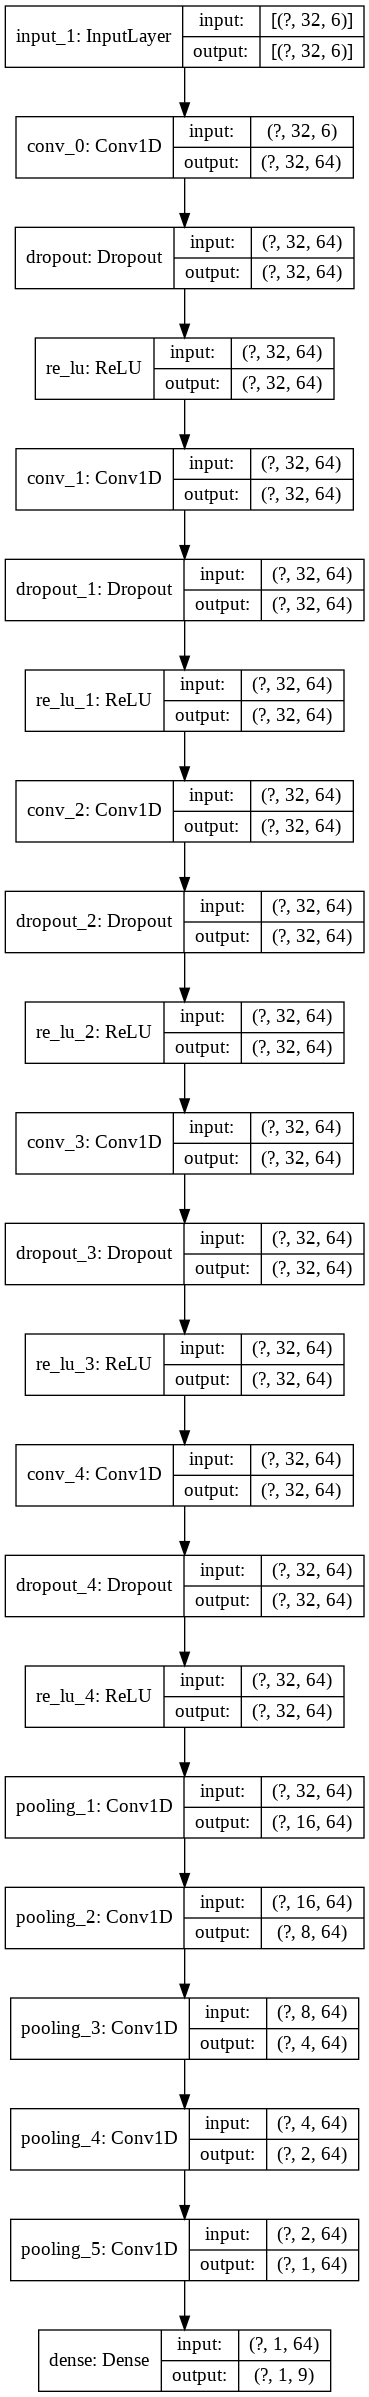

In [ ]:

num_classes = CLASSES

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    this_layer=input_layer
    for c in range(LAYER_COUNT):
      this_layer = keras.layers.Conv1D(filters=64, kernel_size=2,dilation_rate=2**c, padding="same",name="conv_%d"%c)(this_layer)
#      this_layer = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(this_layer)
      this_layer=keras.layers.Dropout(0.2)(this_layer)
      this_layer = keras.layers.ReLU()(this_layer)

    # rather than average pooling, this uses a stack of width 2 convolutions which do 
    # some kind of pooling operation but which is no longer fixed
    count=0
    while this_layer.shape[-2]>1:
      count+=1
      this_layer=keras.layers.Conv1D(filters=64,kernel_size=2,strides=2,padding="valid",name="pooling_%d"%count)(this_layer)

#    this_layer = keras.layers.GlobalAveragePooling1D()(this_layer)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(this_layer)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


#model = make_model(input_shape=x_train.shape[1:])
model = make_model(train_dataset[0][0].shape[1:])
keras.utils.plot_model(model, show_shapes=True)


In [ ]:
train_dataset[0][0].shape[1:]

(32, 6)

In [ ]:
epochs = 500
 
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_sparse_categorical_accuracy"
    )
    #,
    #keras.callbacks.ReduceLROnPlateau(
    #    monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    #)
    #,
    #keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
#history = model.fit(
#    x_train,
#    y_train,
#    batch_size=batch_size,
#    epochs=epochs,
#    callbacks=callbacks,
#    validation_split=0.2,
#    verbose=1,
#)
 
 
history = model.fit(train_dataset,epochs=epochs,callbacks=callbacks,validation_data=validate_dataset)

Epoch 1/500
137/137 [==============================] - 4s 33ms/step - loss: 2.1968 - sparse_categorical_accuracy: 0.1635 - val_loss: 2.1680 - val_sparse_categorical_accuracy: 0.2464
Epoch 2/500
137/137 [==============================] - 3s 25ms/step - loss: 2.1560 - sparse_categorical_accuracy: 0.2158 - val_loss: 2.1950 - val_sparse_categorical_accuracy: 0.2464
Epoch 3/500
137/137 [==============================] - 4s 26ms/step - loss: 2.1057 - sparse_categorical_accuracy: 0.1948 - val_loss: 1.8520 - val_sparse_categorical_accuracy: 0.4035
Epoch 4/500
137/137 [==============================] - 3s 23ms/step - loss: 2.0618 - sparse_categorical_accuracy: 0.2432 - val_loss: 2.1985 - val_sparse_categorical_accuracy: 0.3478
Epoch 5/500
137/137 [==============================] - 3s 23ms/step - loss: 2.1439 - sparse_categorical_accuracy: 0.2491 - val_loss: 2.1496 - val_sparse_categorical_accuracy: 0.3478
Epoch 6/500
137/137 [==============================] - 3s 22ms/step - loss: 2.1888 - spars

In [ ]:
model = keras.models.load_model("best_model.h5")
 
model.evaluate(train_dataset)
test_loss, test_acc = model.evaluate(test_dataset)
 
print("Test accuracy", test_acc)
print("Test loss", test_loss)

68/68 [==============================] - 1s 14ms/step - loss: 0.9678 - sparse_categorical_accuracy: 0.8428
Test accuracy 0.8428308963775635
Test loss 0.9677574038505554


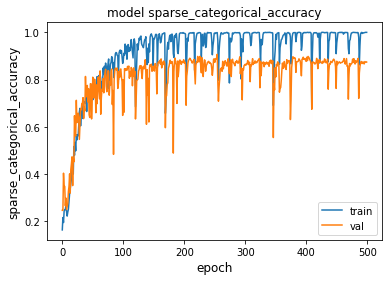

<Figure size 432x288 with 0 Axes>

In [ ]:
metric = "sparse_categorical_accuracy"
 
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
#plt.close()
plt.savefig(('RESULTSFS/9_classes.png'))

Added later - Trying to understand how to generate a confusion matrix




In [ ]:
#history.history

In [ ]:
#model.summary()

In [ ]:
#in_dataset.__dict__

In [ ]:
#train_dataset.__dict__

In [ ]:
#train_dataset[0][0].shape[1:]

In [ ]:
#validate_dataset.__dict__

In [ ]:
#validate_dataset[0][0].shape[1:]

In [ ]:
def make_confusion_matrix(dataset,title):
  print("================")
  print(title)
  print("================")
  print("CONFUSION MATRIX")
  print("================")
  labels = np.concatenate([values[1] for values in dataset])# get all the label batches
  predictionProbabilities= model.predict(dataset) # get the predictions as a probability distribution
  
 
 
  predictions = tf.math.argmax(
    predictionProbabilities, axis=2, output_type=tf.dtypes.int64, name=None) # take argmax - predictions and labels are both now individual numbered values
 
  print(labels.shape, predictions.shape)
  matrix=tf.math.confusion_matrix(
    tf.squeeze(labels),tf.squeeze( predictions), num_classes=9
  )
  print(matrix)
  print("================")
  print("Frequencies")
  print("================")
  lab_freq=tf.reduce_sum(matrix,axis=1)
  pred_freq=tf.reduce_sum(matrix,axis=0)
  print("Labels frequencies:   ",lab_freq)
  print("Predicted frequencies:",pred_freq)
 
  print("Correct predictions:",(["%2.2f"%((matrix[c,c] / lab_freq[c]).numpy()) for c in range(9)]))

In [ ]:
make_confusion_matrix(test_dataset,"TEST DATA CONFUSION MATRIX")

TEST DATA CONFUSION MATRIX
CONFUSION MATRIX
(2176, 1) (2176, 1)
tf.Tensor(
[[480   0   0   0   0   0   0   0   0]
 [  0 224   0   0   0   0   0   0   0]
 [  6   0 101   5  48   0   0   0   0]
 [  0   0  23 190  14   0   0   0  13]
 [  0   0  37  31 140   0   0   0   0]
 [  0   0   0   0   0 192   0   0   0]
 [  0   0  20   8  20  11 165   0   0]
 [  0   0   0   0   0   0   0 163  29]
 [  0   0   0  32  16   0   0  29 179]], shape=(9, 9), dtype=int32)
Frequencies
Labels frequencies:    tf.Tensor([480 224 160 240 208 192 224 192 256], shape=(9,), dtype=int32)
Predicted frequencies: tf.Tensor([486 224 181 266 238 203 165 192 221], shape=(9,), dtype=int32)
Correct predictions: ['1.00', '1.00', '0.63', '0.79', '0.67', '1.00', '0.74', '0.85', '0.70']


In [ ]:
make_confusion_matrix(train_dataset,"TRAIN DATA CONFUSION MATRIX")

TRAIN DATA CONFUSION MATRIX
CONFUSION MATRIX
(4384, 1) (4384, 1)
tf.Tensor(
[[946   0   0   0   0   0   0   0   0]
 [  0 357   0   0   0   0   0   0   0]
 [  0   0 661   1  13   0   0   0   0]
 [  0   0   0 582   0   0   0   0   0]
 [  0   0   0   0 430   0   0   0   0]
 [  0   0   0   0   0 454   0   0   0]
 [  0   0   0   0   0   0 332   0   0]
 [  0   0   0   0   0   0   0 256   0]
 [  0   0   0   0   0   0   0   0 352]], shape=(9, 9), dtype=int32)
Frequencies
Labels frequencies:    tf.Tensor([946 357 675 582 430 454 332 256 352], shape=(9,), dtype=int32)
Predicted frequencies: tf.Tensor([946 357 661 583 443 454 332 256 352], shape=(9,), dtype=int32)
Correct predictions: ['1.00', '1.00', '0.98', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00']


In [ ]:
make_confusion_matrix(validate_dataset,"VALIDATION DATA CONFUSION MATRIX")

VALIDATION DATA CONFUSION MATRIX
CONFUSION MATRIX
(2208, 1) (2208, 1)
tf.Tensor(
[[544   0   0   0   0   0   0   0   0]
 [  0 224   0   0   0   0   0   0   0]
 [  0   0 205  19   0   0   0   0   0]
 [  0   0   9 229  18   0   0   0   0]
 [  0   0  40   0 120   0   0   0   0]
 [  0   0   0   0   0 160   0   0   0]
 [  0   0   0   0  18   9  78   0   0]
 [  0   0   0  12   0  10   0 310  35]
 [  0   0   0   0  10   0   0  26 132]], shape=(9, 9), dtype=int32)
Frequencies
Labels frequencies:    tf.Tensor([544 224 224 256 160 160 105 367 168], shape=(9,), dtype=int32)
Predicted frequencies: tf.Tensor([544 224 254 260 166 179  78 336 167], shape=(9,), dtype=int32)
Correct predictions: ['1.00', '1.00', '0.92', '0.89', '0.75', '1.00', '0.74', '0.84', '0.79']


In [ ]:
import csv   
import datetime
    
# headers
header = [['Run Date Time', 'Number of Classes', 'Batch Size', 'History Size','Epochs','Test Accuracy','Test Loss']]

# data rows of csv file  
rows = [[datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), CLASSES, BATCH_SIZE, HISTORY_SIZE, epochs, test_acc, test_loss ]]
    
# name of csv file  
filename = "outfile_fs_9_classes_info.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  

    # writing the header row 
    csvwriter.writerows(header)         

    # writing the data rows  
    csvwriter.writerows(rows) 